# [ASHRAE - Great Energy Predictor III](https://www.kaggle.com/c/ashrae-energy-prediction/overview)

How much energy will a building consume?


---

Developing energy savings has two key elements: Forecasting future energy usage without improvements, and forecasting energy use after a specific set of improvements have been implemented, like the installation and purchase of investment-grade meters, whose prices continue to fall. One issue preventing more aggressive growth of the energy markets are the lack of cost-effective, accurate, and scalable procedures for forecasting energy use.

**In this competition, you’ll develop accurate predictions of metered building energy usage in the following areas: chilled water, electric, natural gas, hot water, and steam meters. The data comes from over 1,000 buildings over a three-year timeframe.**

With better estimates of these energy-saving investments, large scale investors and financial institutions will be more inclined to invest in this area to enable progress in building efficiencies.

In [1]:
# standard libraries
import pandas as pd
pd.set_option('display.max_columns', None) 
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import os

In [3]:
raw_data_dir = '../data/01_raw'
os.listdir(raw_data_dir)

['.DS_Store',
 '.gitkeep',
 'building_metadata.csv',
 'sample_submission.csv',
 'test.csv',
 'train.csv',
 'weather_test.csv',
 'weather_train.csv']

In [8]:
%%time
# read primary training data and test data
train = pd.read_csv(raw_data_dir + '/train.csv')
test = pd.read_csv(raw_data_dir + '/test.csv')

# read complimentary datasets
weather_train = pd.read_csv(raw_data_dir + '/weather_train.csv')
weather_test = pd.read_csv(raw_data_dir + '/weather_test.csv')
building_metadata = pd.read_csv(raw_data_dir + '/building_metadata.csv')

CPU times: user 48.8 s, sys: 11 s, total: 59.8 s
Wall time: 1min 1s


In [9]:
# Glimpse of data
print('Size of train data', train.shape)
print('Size of test data', test.shape)
print('Size of building_metadata', building_metadata.shape)
print('Size of weather_train data', weather_train.shape)
print('Size of weather_test data', weather_test.shape)

Size of train data (20216100, 4)
Size of test data (41697600, 4)
Size of building_metadata (1449, 6)
Size of weather_train data (139773, 9)
Size of weather_test data (277243, 9)


In [10]:
train.memory_usage()

Index                   80
building_id      161728800
meter            161728800
timestamp        161728800
meter_reading    161728800
dtype: int64

In [11]:
test.memory_usage()

Index                 80
row_id         333580800
building_id    333580800
meter          333580800
timestamp      333580800
dtype: int64

In [12]:
# Reduce Memory Size
def reduce_mem_usage(df, verbose=True):
    num_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in num_types:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

building_metadata = reduce_mem_usage(building_metadata)
weather_train = reduce_mem_usage(weather_train)
weather_test = reduce_mem_usage(weather_test)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)


In [13]:
train.dtypes

building_id        int16
meter               int8
timestamp         object
meter_reading    float32
dtype: object

In [42]:
%%time

def autoSetColType(df, tablename='Unknown'):
    # timestamp
    try:
        df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
        print(f'datetime converted for {tablename}')
    except:
        print(f'\'timestamp\' column may not exist in {tablename}')
    
    # categorical columns
    if 'building_id' in df.columns:
        df['building_id'] = df['building_id'].astype('category')
    if 'meter' in df.columns:
        df['meter'] = df['meter'].astype('category')
    if 'site_id' in df.columns:
        df['site_id'] = df['site_id'].astype('category')
        

autoSetColType(train, 'train')
autoSetColType(test, 'test')
autoSetColType(building_metadata, 'building_meta')
autoSetColType(weather_train, 'weather_train')
autoSetColType(weather_test, 'weather_test')

datetime converted for train
datetime converted for test
'timestamp' column may not exist in building_meta
datetime converted for weather_train
datetime converted for weather_test
CPU times: user 1.31 s, sys: 4.39 s, total: 5.7 s
Wall time: 4.51 s


In [37]:
test.drop('row_id', axis=1, inplace=True)

> ### dataset memory usage reduced and categorical, timestampe data treated. Ready for exploration!
Note: training dataset has 20M rows, and test dataset has ~42M rows

## Target column distribution

In [38]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


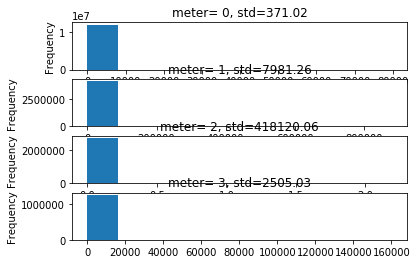

In [94]:
# Univariate
#fig, ax = plt.subplot(4, 1)
for meter, readings in train.groupby('meter')['meter_reading']:
    plt.subplot(4, 1, meter+1)
    plt.title(f'meter= {meter}, std={round(readings.std(), 2)}')
    readings.plot(kind='hist')

#plt.show()

> ### Meter readings vary a lot despite same type of meter across buildings

Sample a building with ID 1266 , meter = 0


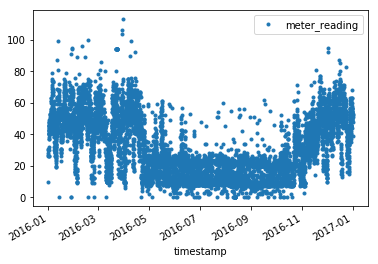

In [45]:
# vs. timestamp (fixing building & meter)

import random
#random.seed(1010)
BUILD_ID = random.randint(0, 1448)
METER = random.randint(0, 3)

print('Sample a building with ID', BUILD_ID, ', meter =', METER)

try:
    sample_train = train.loc[(train['building_id']==BUILD_ID) & (train['meter']==METER)]
    sample_train.plot('timestamp', 'meter_reading', style='.')
except:
    print('Cannot sample')

In [41]:
reading_summary = train.groupby(['meter', 'building_id'])['meter_reading'].agg(['mean', 'std'])

In [46]:
reading_summary.head()

mean         std
meter building_id                        
0     0            146.454971  121.897171
      1             74.865395   61.765388
      2             14.551385   16.063791
      3            235.549973  205.985855
      4            976.556763  779.694092

In [48]:
reading_summary.shape

(2380, 2)

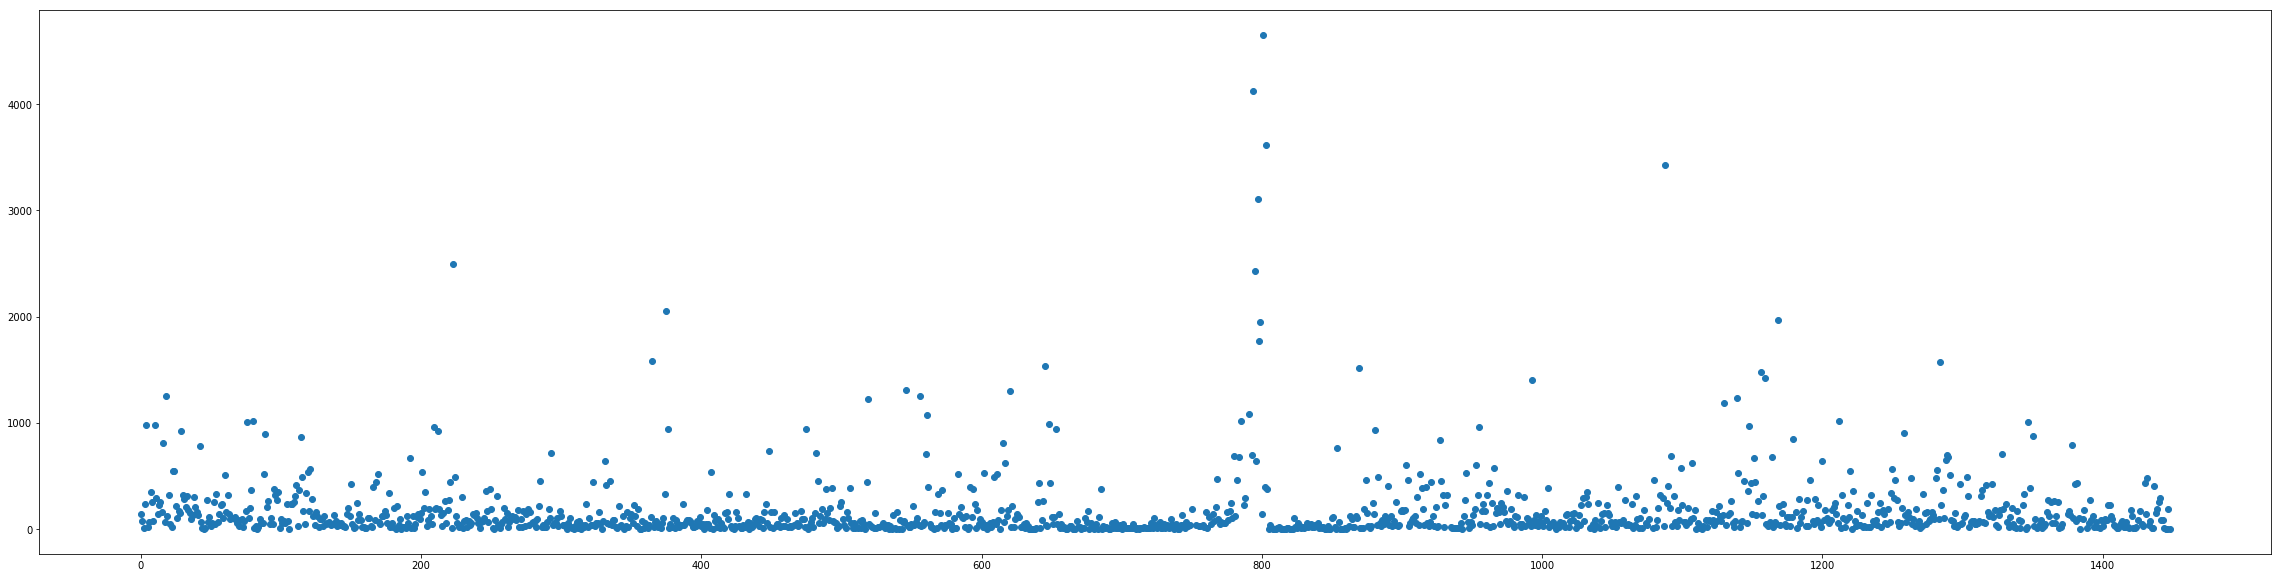

In [67]:
plt.figure(figsize=(40, 10))
plt.scatter(reading_summary.loc[0].index, reading_summary.loc[0, 'mean'])

ValueError: x and y must be the same size

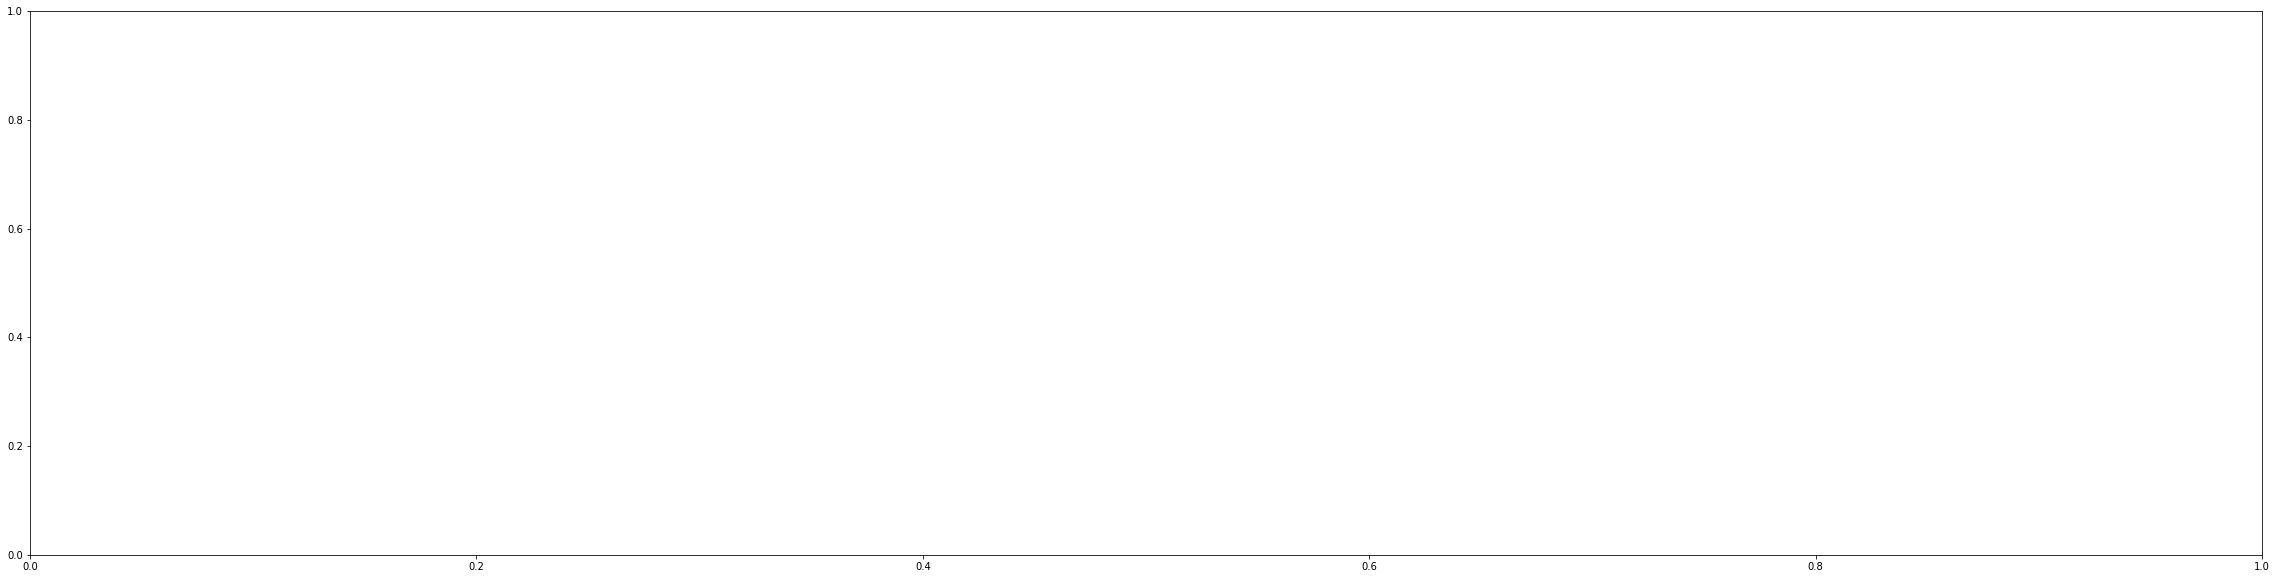

In [73]:
plt.figure(figsize=(40, 10))
plt.scatter(reading_summary.loc[0].index, reading_summary.loc[1, 'mean'])

In [ ]:
plt.figure(figsize=(40, 10))
plt.scatter(reading_summary.loc[0].index, reading_summary.loc[0, 'mean'])

In [ ]:
plt.figure(figsize=(40, 10))
plt.scatter(reading_summary.loc[0].index, reading_summary.loc[0, 'mean'])

In [51]:
print(reading_summary.iloc[reading_summary.index.get_level_values(0)==0, 0].shape)
print(reading_summary.iloc[reading_summary.index.get_level_values(0)==1, 0].shape)
print(reading_summary.iloc[reading_summary.index.get_level_values(0)==2, 0].shape)
print(reading_summary.iloc[reading_summary.index.get_level_values(0)==3, 0].shape)

(1413,)
(498,)
(324,)
(145,)


meter = 0
meter = 1
meter = 2
meter = 3


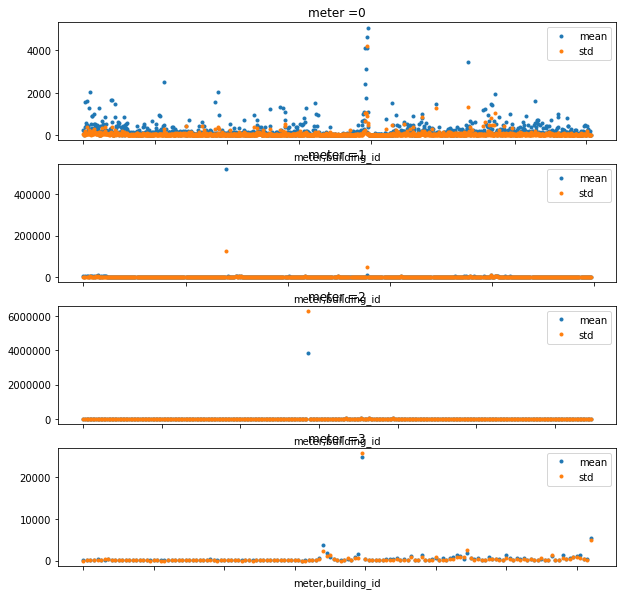

In [169]:
fig, axs = plt.subplots(4)

for meter in range(4):dd
    reading_summary.iloc[reading_summary.index.get_level_values(0)==meter, :].plot(style='.', ax=axs[meter], figsize=(10, 10), title=f'meter ={meter}')

## Missing data or zeros

In [19]:
train['timestamp'].unique(), train['timestamp'].nunique()

(array(['2016-01-01 00:00:00', '2016-01-01 01:00:00',
        '2016-01-01 02:00:00', ..., '2016-12-31 21:00:00',
        '2016-12-31 22:00:00', '2016-12-31 23:00:00'], dtype=object), 8784)

In [12]:
train.describe()

,building_id,meter,meter_reading
count,2.021610e+07,2.021610e+07,2.021610e+07
mean,7.992780e+02,6.624412e-01,2.117121e+03
std,4.269133e+02,9.309921e-01,1.532356e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01
50%,8.950000e+02,0.000000e+00,7.877500e+01
75%,1.179000e+03,1.000000e+00,2.679840e+02
max,1.448000e+03,3.000000e+00,2.190470e+07


In [20]:
train.dtypes

building_id        int64
meter              int64
timestamp         object
meter_reading    float64
dtype: object

In [26]:
def ChangeColType(df):
    df['building_id'] = df['building_id'].astype(str)
    df['meter'] = df['meter'].astype(str)
    df['timestamp'] = pd.to_datetime(df['timestamp'])

In [27]:
ChangeColType(train)
ChangeColType(test)

In [33]:
train.dtypes

building_id              object
meter                    object
timestamp        datetime64[ns]
meter_reading           float64
dtype: object

In [34]:
train['timestamp'].head()

0   2016-01-01
1   2016-01-01
2   2016-01-01
3   2016-01-01
4   2016-01-01
Name: timestamp, dtype: datetime64[ns]

In [ ]:
train.isnull().sum()

## Building

In [76]:
building_metadata.shape # each building has one row

(1449, 6)

In [72]:
building_metadata.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [73]:
building_metadata.describe(include='all')

,site_id,building_id,primary_use,square_feet,year_built,floor_count
count,1449.000000,1449.000000,1449,1449.000000,675.000000,355.000000
unique,NaN,NaN,16,NaN,NaN,NaN
top,NaN,NaN,Education,NaN,NaN,NaN
freq,NaN,NaN,549,NaN,NaN,NaN
mean,6.952381,724.000000,NaN,92111.776398,inf,3.740234
std,5.003432,418.434583,NaN,110769.950997,31.062500,3.333984
min,0.000000,0.000000,NaN,283.000000,1900.000000,1.000000
25%,3.000000,362.000000,NaN,23012.000000,1949.000000,1.000000
50%,5.000000,724.000000,NaN,57673.000000,1970.000000,3.000000
75%,13.000000,1086.000000,NaN,115676.000000,1995.000000,5.000000


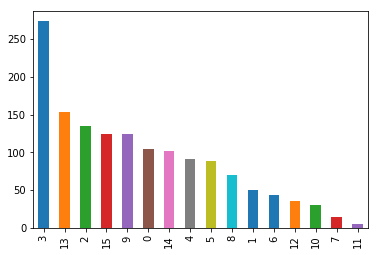

In [172]:
building_metadata.site_id.value_counts().plot(kind='bar')

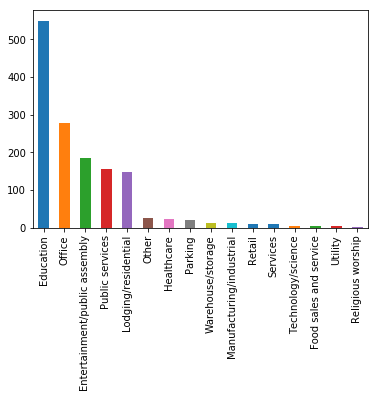

In [173]:
building_metadata.primary_use.value_counts().plot(kind='bar')

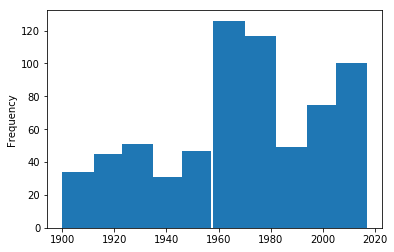

In [176]:
building_metadata.year_built.plot(kind='hist')

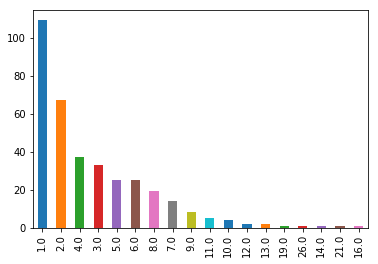

In [177]:
building_metadata.floor_count.value_counts().plot(kind='bar')

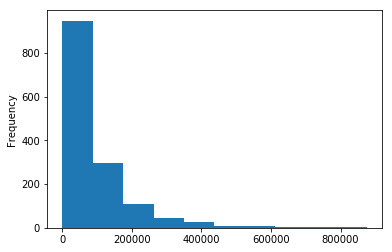

In [178]:
building_metadata.square_feet.plot(kind='hist')

## Weather

In [77]:
weather_train.shape

(139773, 9)

In [78]:
weather_train['timestamp'].describe()

count                  139773
unique                   8784
top       2016-11-04 05:00:00
freq                       16
first     2016-01-01 00:00:00
last      2016-12-31 23:00:00
Name: timestamp, dtype: object

In [80]:
time_diff = weather_train['timestamp'].max() - weather_train['timestamp'].min()


In [88]:
time_diff.total_seconds()/60**2

8783.0

In [74]:
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.00000,NaN,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.09375,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609


In [75]:
weather_train.describe()

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,139773.000000,139718.000000,70600.0,139660.000000,89484.0,129155.0,133505.0,139469.000000
mean,7.478977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.604744,0.000000,0.0,0.000000,NaN,NaN,NaN,0.000000
min,0.000000,-28.906250,0.0,-35.000000,-1.0,968.0,0.0,0.000000
25%,3.000000,7.199219,0.0,0.600098,0.0,1012.0,80.0,2.099609
50%,7.000000,15.000000,2.0,8.296875,0.0,1016.5,190.0,3.099609
75%,11.000000,22.203125,4.0,14.398438,0.0,1021.0,280.0,5.000000
max,15.000000,47.187500,9.0,26.093750,343.0,1046.0,360.0,19.000000


In [180]:
weather_train.groupby(['site_id'])['timestamp'].count()

site_id
0     8784
1     8763
2     8783
3     8780
4     8783
5     8755
6     8782
7     8614
8     8784
9     8780
10    8782
11    8614
12    8755
13    8783
14    8777
15    8454
Name: timestamp, dtype: int64